In [1]:
from numba import cuda

device = cuda.get_current_device(); device.reset()

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import os
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x2401bc23400>)

In [4]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [6]:
data['labels'] = data['labels'].replace(['negative', 'neutral', 'positive'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,1,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,1,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,0,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,2,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,2,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['kor_sentence']

In [8]:
data[:5]

,labels,sentence
0,1,"According to Gran, the company has no plans to..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company's updated strategy fo...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    4846 non-null   int64 
 1   sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [11]:
print('kor_sentence 열의 유니크한 값 :',data['sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4838


In [12]:
duplicate = data[data.duplicated()]

In [13]:
duplicate

,labels,sentence
1099,1,The issuer is solely responsible for the conte...
1416,1,The report profiles 614 companies including ma...
2396,1,Ahlstrom's share is quoted on the NASDAQ OMX H...
2567,1,SSH Communications Security Corporation is hea...
3094,1,Proha Plc ( Euronext :7327 ) announced today (...
3206,1,The company serves customers in various indust...


In [14]:
# 중복 제거
data.drop_duplicates(subset=['sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4838


<AxesSubplot:>

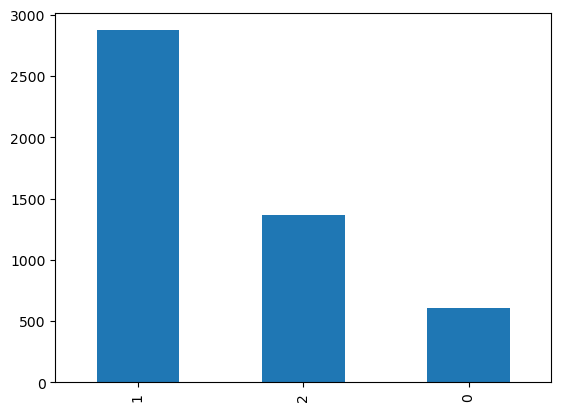

In [15]:
data['labels'].value_counts().plot(kind='bar')

In [16]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0    604
1       1   2872
2       2   1362


In [17]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')

중립의 비율 = 59.363%
긍정의 비율 = 28.152%
부정의 비율 = 12.484%


In [18]:
data

,labels,sentence
0,1,"According to Gran, the company has no plans to..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company's updated strategy fo...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai's beer sales fell by 6.5 per cent t...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


In [19]:
X_data = data['sentence']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4838
레이블의 개수: 4838


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [21]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3870
테스트 샘플의 개수 : 968


In [22]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.354%
긍정 = 28.165%
부정 = 12.481%


In [23]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.401%
긍정 = 28.099%
부정 = 12.5%


In [24]:
max_seq_len = 128

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [27]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id은 세그먼트 인코딩 -> 문장 2개를 분류나 해석하는 task에선 각 문장이 0과 1로 분류됨.
        token_type_id = [0] * max_seq_len

        # 길이가 다를시 오류메세지 띄워줌.
        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [28]:
X_train, y_train, max_seq_len

(4328              Most of the layoffs will be in Finland.
 1558    LONDON ICIS -- Tikkurila has completed the sal...
 3582    Exel's board of directors will propose a divid...
 3454    Virala Oy Ab was allocated by the Board of Dir...
 2002    In China, Finnish Kone that provides elevators...
                               ...                        
 2513    mr Bakman sees also expansion options on the T...
 1613    The company designs, manufactures and markets ...
 3616    In 2007, the Group's net sales stood at EUR 42...
 4078    TietoEnator was down 1.13 pct to 18.38, extend...
 328     EPS for the quarter came in at 0.36 eur, up fr...
 Name: sentence, Length: 3870, dtype: object,
 4328    0
 1558    1
 3582    1
 3454    1
 2002    2
        ..
 2513    1
 1613    1
 3616    1
 4078    0
 328     2
 Name: labels, Length: 3870, dtype: int64,
 128)

In [29]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|                                         | 0/3870 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|█████████████

In [30]:
train_X, train_y

((array([[  101,  2087,  1997, ...,     0,     0,     0],
         [  101,  2414, 24582, ...,     0,     0,     0],
         [  101,  4654,  2884, ...,     0,     0,     0],
         ...,
         [  101,  1999,  2289, ...,     0,     0,     0],
         [  101,  5495,  3406, ...,     0,     0,     0],
         [  101, 20383,  2005, ...,     0,     0,     0]]),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 array([0, 1, 1, ..., 1, 0, 2]))

In [31]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████████████████████████| 968/968 [00:00<00:00, 2674.05it/s]


In [32]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [  101  2087  1997  1996  3913 27475  2097  2022  1999  6435  1012   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [35]:
len(train_X[0]), len(train_y)

(3870, 3870)

In [36]:
# create Tensor datasets
train_data = TensorDataset(torch.tensor(train_X[0]), torch.tensor(train_X[1]), torch.tensor(train_X[2]), torch.tensor(train_y))
valid_data = TensorDataset(torch.tensor(test_X[0]), torch.tensor(test_X[1]), torch.tensor(test_X[2]), torch.tensor(test_y))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [37]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [39]:
# epochs = 5
# valid_loss_min = np.Inf

# train_loss = torch.zeros(epochs)
# valid_loss = torch.zeros(epochs)

# train_acc = torch.zeros(epochs)
# valid_acc = torch.zeros(epochs)

# model.to(device)
# for e in tqdm(range(0, epochs)):
#     model.train()
#     # initialize hidden state 
#     # h = model.init_hidden(batch_size)
#     for inputs in tqdm(train_loader):
#         input_ids = inputs[0].to(device)
#         attention_mask = inputs[1].to(device)
#         labels = inputs[3].type(torch.LongTensor).to(device)
#         optimizer.zero_grad()
#         output = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = output.loss
#         train_loss[e] += loss.item()
#         loss.backward()
        
#         # calculating accuracy
#         # accuracy = acc(output,labels)
#         ps = F.softmax(output.logits, dim=1)
#         top_p, top_class = ps.topk(1, dim=1)
#         equals = top_class == labels.reshape(top_class.shape)
#         train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
        
#         #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#         # nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()
#     train_loss[e] /= len(train_loader)
#     train_acc[e] /= len(train_loader)

    
#     model.eval()
#     for inputs in tqdm(valid_loader):
#         input_ids = inputs[0].to(device)
#         attention_mask = inputs[1].to(device)
#         labels = inputs[3].type(torch.LongTensor).to(device)

#         output = model(input_ids, attention_mask=attention_mask, labels=labels)
#         val_loss = output.loss
#         valid_loss[e] += val_loss.item()

#         ps = F.softmax(output.logits, dim=1)
#         top_p, top_class = ps.topk(1, dim=1)
#         equals = top_class == labels.reshape(top_class.shape)
#         valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
#     valid_loss[e] /= len(valid_loader)
#     valid_acc[e] /= len(valid_loader)
    
#     print(f'Epoch {e+1}') 
#     print(f'train_loss : {train_loss[e]}, val_loss : {valid_loss[e]}')
#     print(f'train_accuracy : {train_acc[e]*100}, val_accuracy : {valid_acc[e]*100}')
#     if valid_loss[e] <= valid_loss_min:
#         torch.save(model, 'bert_model.pth')
#         torch.save(model.state_dict(), 'bert_model_state_dict.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[e]))
#         valid_loss_min = valid_loss[e]
#     print(25*'==')

In [163]:
import os
import pandas as pd

path = "C:/Users/chan/Documents/GitHub/ML/test_MSFT/"
news_df = pd.DataFrame(columns=["title", "content"])

for txts in os.listdir(path):
    full_path = os.path.join(path, txts)  # 파일 전체 경로 생성
    if full_path.endswith('header.txt'):
        continue
    if os.path.isfile(full_path):  # 파일인지 확인
        with open(full_path, "r", encoding="utf-8") as txt_file:
            title = txt_file.readline().strip()
            content = txt_file.read().replace('\n', ' ')
            # DataFrame 생성 후 concat 함수를 사용하여 추가
            new_row = pd.DataFrame({"title": [title], "content": [content]})
            news_df = pd.concat([news_df, new_row], ignore_index=True)

news_df


,title,content
0,"Tue, 06 Apr 2021 07:00:00 GMT",Emails and other communications sent between ...
1,"Mon, 12 Apr 2021 07:00:00 GMT","REDMOND, Wash., and BURLINGTON, Mass., April ..."
2,"Thu, 08 Sep 2022 07:00:00 GMT",[Editor’s note: “An Incredible Stock Market M...
3,"Thu, 08 Sep 2022 07:00:00 GMT",Microsoft (Nasdaq: MSFT) has received approva...
4,"Thu, 08 Sep 2022 07:00:00 GMT","Hackathon will be held across Delhi NCR, Bang..."
...,...,...
3799,"Tue, 06 Sep 2022 07:00:00 GMT",Two-factor authentication is an important fea...
3800,"Wed, 07 Sep 2022 07:00:00 GMT","NEW YORK, Sept. 7, 2022 /PRNewswire/ -- Follo..."
3801,"Wed, 07 Sep 2022 07:00:00 GMT",Following the recent launch of its first four...
3802,"Wed, 07 Sep 2022 07:00:00 GMT",As big data center operators navigate the gro...


In [134]:
# import os
# import pandas as pd

# path = "C:/Users/chan/Documents/GitHub/ML/articles/"
# news_df = pd.DataFrame(columns=["title", "content"])


# for txts in os.listdir(path):
    
#     full_path = os.path.join(path, txts)  # 파일 전체 경로 생성
#     if os.path.isfile(full_path):  # 파일인지 확인
#         with open(full_path, "r", encoding="utf-8") as txt_file:
#             title = txt_file.readline().strip()
#             content = txt_file.read().replace('\n', ' ')
#             news_df = news_df.append({"title": title, "content": content}, ignore_index=True)
# news_df

In [164]:
# 데이터프레임의 'title'과 'content'를 이용하여 입력 데이터 생성
inputs = [content for content in news_df['content']]

# 입력 데이터를 BERT 모델의 입력 형식에 맞게 변환
max_length = 128
input_ids = []
attention_masks = []

for content in inputs:
    encoded_dict = tokenizer.encode_plus(
                        content,                    # content
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

C:\Users\chan\anaconda3\envs\ng\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [165]:
predict_model = torch.load("bert_model_loss0.34.pth", map_location=torch.device('cpu'))
predict_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [166]:
predicted_labels = []

for inputs in tqdm(zip(input_ids, attention_masks)):
    input_ids = inputs[0].to(device)
    attention_mask = inputs[1].to(device)
    output = predict_model(input_ids, attention_mask=attention_mask)

    ps = F.softmax(output.logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    predicted_labels.append(top_class.item())

predict_df = pd.DataFrame({'predicted_label': predicted_labels})
news_df["predict"] = predict_df
news_df.to_csv('predicted_news.csv', index=False)

3804it [04:15, 14.91it/s]


In [167]:
news_df

,title,content,predict
0,"Tue, 06 Apr 2021 07:00:00 GMT",Emails and other communications sent between ...,1
1,"Mon, 12 Apr 2021 07:00:00 GMT","REDMOND, Wash., and BURLINGTON, Mass., April ...",2
2,"Thu, 08 Sep 2022 07:00:00 GMT",[Editor’s note: “An Incredible Stock Market M...,1
3,"Thu, 08 Sep 2022 07:00:00 GMT",Microsoft (Nasdaq: MSFT) has received approva...,0
4,"Thu, 08 Sep 2022 07:00:00 GMT","Hackathon will be held across Delhi NCR, Bang...",1
...,...,...,...
3799,"Tue, 06 Sep 2022 07:00:00 GMT",Two-factor authentication is an important fea...,1
3800,"Wed, 07 Sep 2022 07:00:00 GMT","NEW YORK, Sept. 7, 2022 /PRNewswire/ -- Follo...",1
3801,"Wed, 07 Sep 2022 07:00:00 GMT",Following the recent launch of its first four...,1
3802,"Wed, 07 Sep 2022 07:00:00 GMT",As big data center operators navigate the gro...,0


In [168]:
import os
import pandas as pd

# 데이터프레임과 데이터 로드 부분은 생략합니다.

# 'title' 열에서 날짜와 시간을 분리
news_df['date'] = pd.to_datetime(news_df['title']).dt.date  # 날짜 추출
news_df['time'] = pd.to_datetime(news_df['title']).dt.time  # 시간 추출

# 날짜별로 그룹화하고, 'predict' 열에 대한 평균을 계산
grouped_df = news_df.groupby('date').agg({
    'title': lambda x: x.tolist(),
    'content': lambda x: x.tolist(),
    'predict': lambda x: round(x.mean(), 3)  
})

grouped_df.reset_index(inplace=True)  # 인덱스 리셋

# 결과 출력
grouped_df[['date', 'title', 'content', 'predict']]


,date,title,content,predict
0,2021-04-06,"[Tue, 06 Apr 2021 07:00:00 GMT, Tue, 06 Apr 20...",[ Emails and other communications sent between...,1.000
1,2021-04-07,"[Wed, 07 Apr 2021 07:00:00 GMT]",[ Before we can do any predictive modeling or ...,1.000
2,2021-04-08,"[Thu, 08 Apr 2021 07:00:00 GMT, Thu, 08 Apr 20...",[ The tech giant has just landed a blockbuster...,1.333
3,2021-04-09,"[Fri, 09 Apr 2021 07:00:00 GMT]",[ A Boston Dynamics robot has been videoed tak...,1.000
4,2021-04-12,"[Mon, 12 Apr 2021 07:00:00 GMT, Mon, 12 Apr 20...","[ REDMOND, Wash., and BURLINGTON, Mass., April...",1.500
...,...,...,...,...
925,2024-05-07,"[Tue, 07 May 2024 07:00:00 GMT, Tue, 07 May 20...",[ Microsoft Corporation’s quarterly revenue qu...,1.200
926,2024-05-08,"[Wed, 08 May 2024 12:10:00 GMT, Wed, 08 May 20...",[ Below is Validea's guru fundamental report f...,1.062
927,2024-05-09,"[Thu, 09 May 2024 05:42:30 GMT, Thu, 09 May 20...",[ Microsoft (MSFT) closed at $266.65 in the la...,2.000
928,2024-05-10,"[Fri, 10 May 2024 12:46:06 GMT, Fri, 10 May 20...",[ Investment management company Vulcan Value P...,1.188


In [169]:
result_df = grouped_df[['date', 'predict']]
result_df

,date,predict
0,2021-04-06,1.000
1,2021-04-07,1.000
2,2021-04-08,1.333
3,2021-04-09,1.000
4,2021-04-12,1.500
...,...,...
925,2024-05-07,1.200
926,2024-05-08,1.062
927,2024-05-09,2.000
928,2024-05-10,1.188


In [170]:
import os
import pandas as pd

# 데이터프레임과 데이터 로드 부분은 생략합니다.

# 'title' 열에서 날짜와 시간을 분리
news_df['date'] = pd.to_datetime(news_df['title']).dt.date  # 날짜 추출
news_df['time'] = pd.to_datetime(news_df['title']).dt.time  # 시간 추출

# 'date' 열을 datetime 형식으로 다시 변환
news_df['date'] = pd.to_datetime(news_df['date'])

# 날짜별로 그룹화하고, 'predict' 열에 대한 평균을 계산
grouped_df = news_df.groupby('date').agg({
    'title': lambda x: x.tolist(),
    'content': lambda x: x.tolist(),
    'predict': lambda x: round(x.mean(), 3)  
})

grouped_df.reset_index(inplace=True)  # 인덱스 리셋

# 모든 날짜를 포함하는 날짜 범위 생성
all_dates = pd.date_range(start=grouped_df['date'].min(), end=grouped_df['date'].max(), freq='D')
# 새로운 DataFrame 생성 후 기존 데이터와 병합
complete_df = pd.DataFrame(all_dates, columns=['date'])
complete_df['date'] = pd.to_datetime(complete_df['date'])  # 날짜를 datetime으로 변환
complete_df = complete_df.merge(grouped_df, on='date', how='left')
# 누락된 'predict' 값을 이전 값으로 채우기
complete_df['predict'] = complete_df['predict'].fillna(method='ffill')

# 'date'와 'predict' 열만 선택하여 결과 출력
result_df = complete_df[['date', 'predict']]
result_df


,date,predict
0,2021-04-06,1.000
1,2021-04-07,1.000
2,2021-04-08,1.333
3,2021-04-09,1.000
4,2021-04-10,1.000
...,...,...
1127,2024-05-07,1.200
1128,2024-05-08,1.062
1129,2024-05-09,2.000
1130,2024-05-10,1.188


In [171]:
result_df = result_df.drop(len(result_df) - 1)
result_df

,date,predict
0,2021-04-06,1.000
1,2021-04-07,1.000
2,2021-04-08,1.333
3,2021-04-09,1.000
4,2021-04-10,1.000
...,...,...
1126,2024-05-06,1.393
1127,2024-05-07,1.200
1128,2024-05-08,1.062
1129,2024-05-09,2.000


<h1>기간범위중 맨앞 데이터가 없을경우 1로채운다


In [172]:
from datetime import datetime, timedelta

start_date = datetime.strptime('2021-04-05', '%Y-%m-%d')
end_date = datetime.strptime('2024-05-10', '%Y-%m-%d')

# 주어진 범위 내에 있는 날짜 생성
missing_dates = pd.date_range(start=start_date, end=end_date).difference(result_df['date'])

# 새로운 날짜와 예측값 추가
for date in missing_dates:
    result_df = result_df.append({'date': date, 'predict': 1.0}, ignore_index=True)

# 날짜 기준으로 데이터프레임 정렬
result_df = result_df.sort_values('date').reset_index(drop=True)
result_df

C:\Users\chan\AppData\Local\Temp\ipykernel_31808\1797439696.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'date': date, 'predict': 1.0}, ignore_index=True)


,date,predict
0,2021-04-05,1.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.333
4,2021-04-09,1.000
...,...,...
1127,2024-05-06,1.393
1128,2024-05-07,1.200
1129,2024-05-08,1.062
1130,2024-05-09,2.000


<AxesSubplot:>

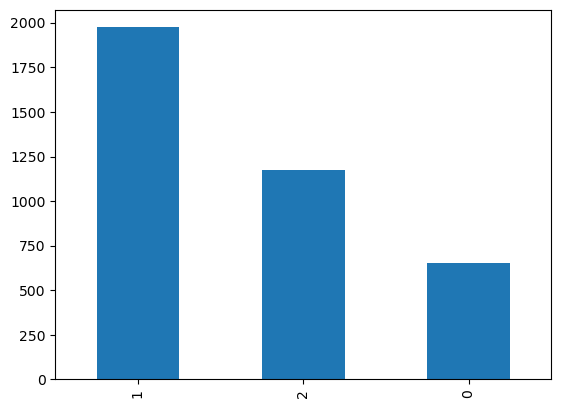

In [173]:
news_df['predict'].value_counts().plot(kind='bar')

In [174]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web # 주식 데이터를 얻어오기 위해 사용
import datetime # 시간 처리
import matplotlib.pyplot as plt
import yfinance as yf
import FinanceDataReader as fdr
from prophet import Prophet
%matplotlib inline

# 데이터를 가져오고 나서, 이동평균을 구해야함.
# 국내 종목 : 삼성전자

# 날짜 : 3년 간 삼성전자 주가 분석(2017.01.02) ~ (2021.06.07)
start = datetime.datetime( 2021, 4, 5 )
end = datetime.datetime( 2024, 5, 11)

In [175]:
def makeStockChart(code, sDay, eDay):
    """
    이 함수는 종목코드와 조회 시작일, 종료일을 넣으면 차트를 그려준다.
    이동 평균선은 5일, 20일, 60일, 120일을 지원한다.
    """
    
    # 데이터 가져오기
    data = yf.download(code, start=sDay, end=eDay)
    
    # 이동 평균 계산
    data['5MA'] = data['Adj Close'].rolling(window=5).mean()
    data['20MA'] = data['Adj Close'].rolling(window=20).mean()
    data['60MA'] = data['Adj Close'].rolling(window=60).mean()
    data['120MA'] = data['Adj Close'].rolling(window=120).mean()
    
    # 차트 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close')
    plt.plot(data['5MA'], label='5MA')
    plt.plot(data['20MA'], label='20MA')
    plt.plot(data['60MA'], label='60MA')
    plt.plot(data['120MA'], label='120MA')
    plt.title(f"{code}'s Stock Chart")
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


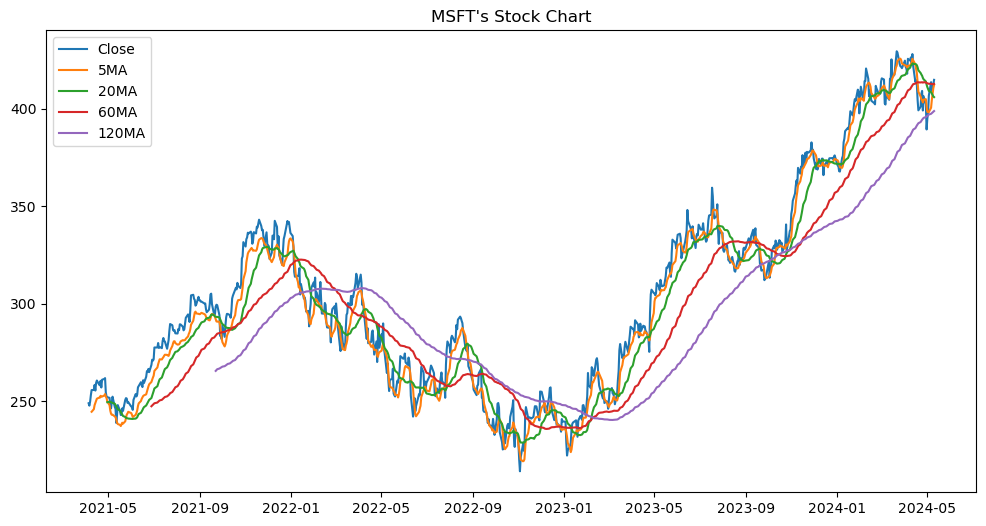

In [176]:
code_name = 'MSFT'
makeStockChart(code_name, start, end)

In [177]:
datas = yf.download(code_name, start=start, end=end)

# 컬럼 ds(YYYY-MM-DD), y(종가 : Close) 구성
# 해당 구저의 DateFrame만들기 위한 딕셔너리 선언

dic = {
    'ds' : datas.index,
    'y' : datas.Close,
    # 'volume': datas.Volume
    
}

# ds 와 y를 컬럼으로 갖는 데이터 프레임 생성
finance_df = pd.DataFrame( dic )

#인덱스 초기화(원본 까지 적용)
finance_df.reset_index( inplace=True )

# 'ds' 컬럼과 중복되는 'Date' 컬럼 제거
del finance_df['Date']

# 페이스북의 시계열 예측 모델에 사용한 데이터 준비
finance_df.head(5)
finance_df.tail(5)
# print(len(finance_df))
finance_df

[*********************100%%**********************]  1 of 1 completed


,ds,y
0,2021-04-05,249.070007
1,2021-04-06,247.860001
2,2021-04-07,249.899994
3,2021-04-08,253.250000
4,2021-04-09,255.850006
...,...,...
777,2024-05-06,413.540009
778,2024-05-07,409.339996
779,2024-05-08,410.540009
780,2024-05-09,412.320007


In [178]:
import pandas as pd
import datetime

# 정해진 기간을 데이터프레임화


# start와 end 사이의 날짜를 포함하는 DataFrame 생성
date_range = pd.date_range(start=start, end=end)
df_date_range = pd.DataFrame(date_range, columns=['date'])

# 다른 데이터프레임 예시 생성


# df_date_range에서 other_dates의 date와 겹치는 날짜를 제거
df_filtered = df_date_range[~df_date_range['date'].isin(finance_df['ds'])]
df_filtered #미국주식 안열리는 날 계산한 데이터 프레임

,date
5,2021-04-10
6,2021-04-11
12,2021-04-17
13,2021-04-18
19,2021-04-24
...,...
1118,2024-04-27
1119,2024-04-28
1125,2024-05-04
1126,2024-05-05


In [179]:
# 겹치는 날짜 
common_dates = result_df[result_df['date'].isin(df_filtered['date'])]['date']

# 겹치는 날짜를 갖는 행 제거
result_filtered = result_df[~result_df['date'].isin(common_dates)]
# result_filtered = result_filtered.iloc[:-1]
result_filtered

,date,predict
0,2021-04-05,1.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.333
4,2021-04-09,1.000
...,...,...
1127,2024-05-06,1.393
1128,2024-05-07,1.200
1129,2024-05-08,1.062
1130,2024-05-09,2.000


In [180]:
result_filtered.reset_index(inplace=True)
result_filtered

,index,date,predict
0,0,2021-04-05,1.000
1,1,2021-04-06,1.000
2,2,2021-04-07,1.000
3,3,2021-04-08,1.333
4,4,2021-04-09,1.000
...,...,...,...
777,1127,2024-05-06,1.393
778,1128,2024-05-07,1.200
779,1129,2024-05-08,1.062
780,1130,2024-05-09,2.000


In [181]:
result_filtered_future = result_filtered.copy()
result_filtered_future = result_filtered_future.drop(columns=['index'])
result_filtered_future


,date,predict
0,2021-04-05,1.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.333
4,2021-04-09,1.000
...,...,...
777,2024-05-06,1.393
778,2024-05-07,1.200
779,2024-05-08,1.062
780,2024-05-09,2.000


In [153]:
# import pandas as pd

# # finance_df와 result_filtered_future 데이터프레임을 병합하여 새로운 데이터프레임 생성
# result_filtered_future = pd.concat([result_filtered_future, finance_df['volume']], axis=1)

# # 결과 확인
# result_filtered_future


<h1>future -> forecast를 위한 값 추가</h1>

In [182]:
# 'predict' 열에만 평균 값 추가
mean_last_seven = result_filtered_future['predict'].iloc[-7:].mean()
# mean_last_seven_1 = result_filtered_future['volume'].iloc[-7:].mean()
# 다음 날짜 계산
last_date = result_filtered_future['date'].iloc[-1]
next_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)

# 데이터프레임에 새로운 행 추가
new_row = {'date': next_date, 'predict': round(mean_last_seven, 3)}  # 소수점 세 자리까지 반올림
result_filtered_future = result_filtered_future.append(new_row, ignore_index=True)

# 'predict' 열의 소수점 자리 수 설정
result_filtered_future['predict'] = result_filtered_future['predict'].round(3)

result_filtered_future


C:\Users\chan\AppData\Local\Temp\ipykernel_31808\3564898628.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_filtered_future = result_filtered_future.append(new_row, ignore_index=True)


,date,predict
0,2021-04-05,1.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.333
4,2021-04-09,1.000
...,...,...
778,2024-05-07,1.200
779,2024-05-08,1.062
780,2024-05-09,2.000
781,2024-05-10,1.188


In [183]:
finance_df = pd.concat([finance_df, result_filtered['predict']], axis=1)

finance_df

,ds,y,predict
0,2021-04-05,249.070007,1.000
1,2021-04-06,247.860001,1.000
2,2021-04-07,249.899994,1.000
3,2021-04-08,253.250000,1.333
4,2021-04-09,255.850006,1.000
...,...,...,...
777,2024-05-06,413.540009,1.393
778,2024-05-07,409.339996,1.200
779,2024-05-08,410.540009,1.062
780,2024-05-09,412.320007,2.000


In [156]:
# finance_df

            ds        yhat  yhat_lower  yhat_upper
772 2024-04-29  405.423524  396.802813  413.934755
773 2024-04-30  404.594391  396.474844  414.245876
774 2024-05-01  404.102440  395.340397  413.050797
775 2024-05-02  404.611521  396.824213  412.989680
776 2024-05-03  404.626766  395.778929  413.290099
777 2024-05-06  403.439487  394.841223  412.603474
778 2024-05-07  402.381132  393.836672  411.245570
779 2024-05-08  402.673951  393.431728  410.898043
780 2024-05-09  404.334885  395.509719  412.906917
781 2024-05-10  403.206331  394.534977  412.258033
782 2024-05-11 -643.920281 -652.880381 -634.954960


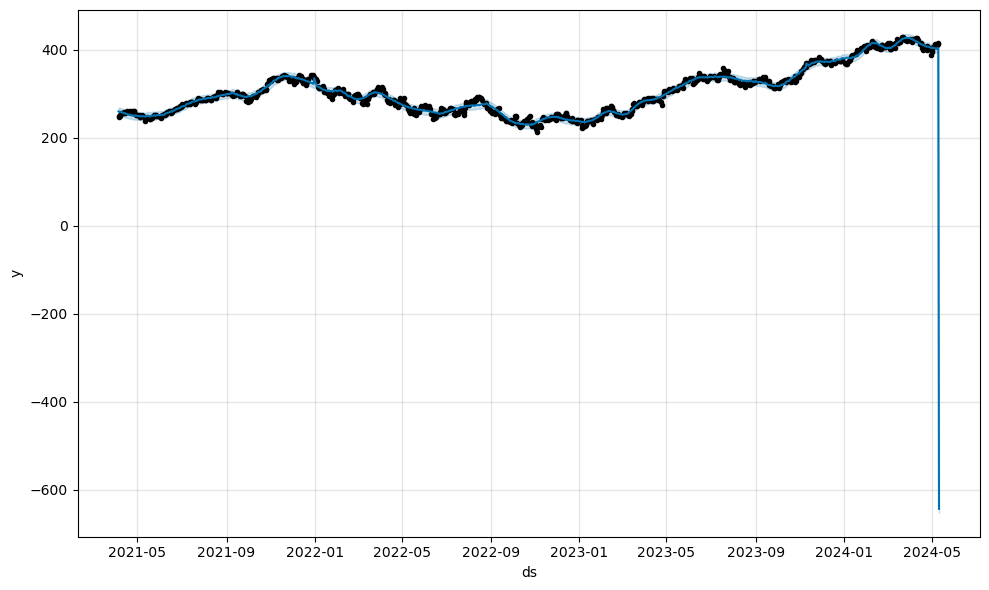

In [184]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
# model = Prophet(changepoint_prior_scale=0.31150996767072153,
#                 changepoint_range=0.8409742702125196, 
#                 daily_seasonality=True,
#                 holidays_prior_scale=0.5429118795932729, 
#                 seasonality_mode='multiplicative',
#                 seasonality_prior_scale=1.2964727674363865,
#                 weekly_seasonality=True,
#                 n_changepoints=25,
#                 growth='linear',
#                 yearly_seasonality=True)
# model = Prophet(changepoint_prior_scale=0.3225469441035442,
#                 changepoint_range=0.8959729377163332, 
#                 daily_seasonality=True,
#                 holidays_prior_scale=0.48141493972833566, 
#                 seasonality_mode='multiplicative',
#                 seasonality_prior_scale=0.27212358941114123,
#                 weekly_seasonality=False,
#                 n_changepoints=24,
#                 growth='linear',
#                 yearly_seasonality=True) # cross_validation(m, initial='250 days', period='10 days', horizon='1 days')
model = Prophet(changepoint_prior_scale=0.1541135741310533,
                changepoint_range=0.7075492829641814, 
                daily_seasonality=False,
                holidays_prior_scale=0.5080563204252423, 
                seasonality_mode='multiplicative',
                seasonality_prior_scale=4.043977713268082,
                weekly_seasonality=True,
                n_changepoints=25,
                growth='linear',
                yearly_seasonality=True) #cross_validation(m, initial='250 days', period='20 days', horizon='1 days')
                
model.add_country_holidays(country_name='US')
model.add_regressor('predict')
# 데이터 학습 시작 -> 기계학습
model.fit( finance_df )
# print(model.params['beta'])
# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값

future = model.make_future_dataframe( periods = 1)
future['predict'] = result_filtered_future['predict'].values
# 주가 예측
forecast = model.predict( future )

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
''' 

# 모델 예측 결과 출력
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# 모델 예측 그래프 출력
fig = model.plot(forecast)

plt.show(fig)


<h1>prophet 하이퍼파라미터 설정 model로 예측 돌리기</h1>

In [64]:
# import yfinance as yf
# import datetime

# # Tesla 주식에 대한 데이터를 가져오기
# tsla = yf.Ticker("TSLA")
# tsla_income = tsla.income_stmt.T
# tsla_balance = tsla.balance_sheet.T
# tsla_cash = tsla.cashflow.T
# tsla_combined = pd.concat([tsla_income, tsla_balance, tsla_cash], axis=1)

# # 필요한 열만 선택하여 새로운 데이터프레임 생성
# tsla_selected = tsla_combined[["Net Income Common Stockholders", "Basic EPS", "Working Capital", "Operating Cash Flow"]]

# # 결과 출력
# tsla_selected = tsla_selected.fillna(0)
# tsla_selected




In [65]:
# from prophet.diagnostics import cross_validation, performance_metrics
# import matplotlib.pyplot as plt
# model = Prophet( changepoint_prior_scale= 0.4469497270584068, 
# changepoint_range= 0.8117567477475541, 
# daily_seasonality= True,
# seasonality_mode='multiplicative',
# growth= 'linear', 
# holidays_prior_scale= 0.05160382047585584, 
# n_changepoints= 22, 
# seasonality_prior_scale= 0.3523031728392127, 
# weekly_seasonality= False, 
# yearly_seasonality= True
#                ) 

# model.add_country_holidays(country_name='US')
# model.add_regressor('predict')
# # 데이터와 Prophet 모델 설정 부분은 생략하고, 모델 학습 부분부터 시작
# model.fit(finance_df)

# # 크로스 밸리데이션 설정
# df_cv = cross_validation(model, initial='20 days', period='2 days', horizon='1 days')

# # 크로스 밸리데이션 결과의 성능 지표 계산
# df_p = performance_metrics(df_cv)
# print(df_p[['rmse', 'mae','mape']])


In [ ]:
# import pickle

# # 모델 객체를 파일로 저장
# with open("prophet_model.pkl", "wb") as f:
#     pickle.dump(model, f)


In [ ]:
# # 저장된 모델 파일을 로드
# with open("prophet_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

<h1>buy,sell 출력 json파일 만들 코드

In [ ]:

# initial_capital = 1000.0  # 초기 자본
# current_capital = initial_capital  # 현재 자본, 거래 과정에서 업데이트됨
# shares_owned = 0
# position = 'None'  # 현재 포지션 상태
# day = 1
# month_day = 30
# # 시뮬레이션 수익 계산
# profit = 0.0

# actual_prices = finance_df.set_index('ds')['y'][-(day+31):-(day)]  # 마지막 31일 실제 가격
# predicted_prices = forecast.set_index('ds')['yhat'][-(day+31):-(day)]

# dates = [actual_prices.index[0] - pd.Timedelta(days=1)]  # 첫 거래일 이전 날짜 추가
# capitals = [initial_capital]

# # 날짜와 함께 매도, 매수, 보유 결과를 출력하기 위해 수정
# for i in range(month_day):
#     today_date = actual_prices.index[i]
#     today_price = actual_prices.iloc[i]
#     predicted_next_day_price = predicted_prices.iloc[i]

#     # 조건을 검사하고 매수, 매도, 보유를 결정
#     if i < (month_day-1):  # 마지막 날짜를 제외한 모든 날에 대해 검사
#         next_day_price = actual_prices.iloc[i+1]
#         predicted_change = predicted_next_day_price - today_price

#         # 매수 조건
#         if predicted_change > 0 and position != 'Hold':
#             shares_owned = current_capital / today_price
#             current_capital = 0
#             position = 'Hold'
#             print(f"{today_date} - 매수: {today_price} (실제 다음날 가격: {next_day_price:,.3f}, 예측된 다음날 가격: {predicted_next_day_price:,.3f})")

#         # 매도 조건
#         elif predicted_change < 0 and position == 'Hold':
#             current_capital = shares_owned * next_day_price
#             shares_owned = 0
#             position = 'None'
#             print(f"{today_date} - 매도: {next_day_price} (실제 다음날 가격: {next_day_price:,.3f}, 예측된 다음날 가격: {predicted_next_day_price:,.3f})")

#         # 보유 조건
#         elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
#             print(f"{today_date} - 보유: {today_price}")
#         else:
#     # 보유 또는 기타 조건 로직
#             if position == 'Hold':
#                 print(f"{today_date} - 보유: 현재 가격 {today_price:,.3f}, 예측된 다음날 가격 {predicted_next_day_price:,.3f}")
#             else:
#                 print(f"{today_date} - 조치 없음: 현재 가격 {today_price:,.3f}, 예측된 다음날 가격 {predicted_next_day_price:,.3f}")
#     dates.append(today_date)
#     capitals.append(current_capital + (shares_owned * today_price))
# # 마지막 날 주식을 모두 매도하고 최종 자본 계산
# if position == 'Hold' and shares_owned > 0:
#     final_price = actual_prices.iloc[-1]
#     current_capital = shares_owned * final_price
#     shares_owned = 0
#     print(f"{actual_prices.index[-1]} - 마지막 날 매도: {final_price:,.3f}")

# profit = current_capital - initial_capital  # 최종 이익 계산
# return_rate = ((current_capital - initial_capital) / initial_capital) * 100
# # 결과 출력
# print(f"초기 자본: ${initial_capital:,.3f}")
# print(f"최종 자본: ${current_capital:,.3f}")
# print(f"수익: ${profit:,.3f}")
# print(f"수익률: {return_rate:.2f}%")

In [ ]:
# import pandas as pd

# # 초기 자본 설정
# initial_capital = 1000.0

# # 사용자로부터 시작일과 종료일 입력 받기
# start_date = '2023-03-05'
# end_date_1 = '2024-04-04'
# end_date_2 = '2024-04-05'

# # 입력된 날짜 범위로 데이터 필터링
# filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
# filtered_df_forcast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]
# # 현재 자본 및 보유 주식 수 초기화
# current_capital = initial_capital
# shares_owned = 0

# # 현재 포지션 초기화
# position = 'None'

# # 실제 및 예측 주식 가격 설정
# actual_prices = filtered_df.set_index('ds')['y']
# predicted_prices = filtered_df_forcast.set_index('ds')['yhat']

# # 시뮬레이션 시작
# for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
#     predicted_change = predicted_next_day_price - today_price

#     # 매수 조건
#     if predicted_change > 0 and position != 'Hold':
#         shares_to_buy = current_capital / today_price
#         shares_owned += shares_to_buy
#         current_capital -= shares_to_buy * today_price
#         position = 'Hold'
#         print(f"{date} - 매수: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

#     # 매도 조건
#     elif predicted_change < 0 and position == 'Hold':
#         current_capital += shares_owned * today_price
#         shares_owned = 0
#         position = 'None'
#         print(f"{date} - 매도: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

#     # 보유 조건
#     elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
#         print(f"{date} - 보유: ${today_price:.3f}")
#     else:
#         # 조치 없음 또는 보유
#         if position == 'Hold':
#             print(f"{date} - 보유: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")
#         else:
#             print(f"{date} - 조치 없음: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")

# # 최종 자본 및 수익률 계산
# final_capital = current_capital + (shares_owned * actual_prices.iloc[-1])
# profit = final_capital - initial_capital
# return_rate = (profit / initial_capital) * 100

# # 결과 출력
# print(f"초기 자본: ${initial_capital:.3f}")
# print(f"최종 자본: ${final_capital:.3f}")
# print(f"수익: ${profit:.3f}")
# print(f"수익률: {return_rate:.3f}%")


In [ ]:
# print(actual_prices)
# predicted_prices.shift(-1).values
# predicted_prices

In [185]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np




param_space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', np.log(0.001), np.log(0.5)),  # changepoint_prior_scale 범위를 수정
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', np.log(0.01), np.log(10)),   # seasonality_prior_scale 범위를 수정
    'holidays_prior_scale': hp.loguniform('holidays_prior_scale', np.log(0.01), np.log(10)),         # holidays_prior_scale 범위를 수정
    'seasonality_mode': hp.choice('seasonality_mode', ['additive', 'multiplicative']),
    'changepoint_range': hp.uniform('changepoint_range', 0.7, 0.95),
    'yearly_seasonality': hp.choice('yearly_seasonality', [True, False]),
    'weekly_seasonality': hp.choice('weekly_seasonality', [True, False]),
    'daily_seasonality': hp.choice('daily_seasonality', [True, False]),
    'n_changepoints': hp.quniform('n_changepoints', 10, 25, 1)
}

# 최적화할 목적 함수 정의
def objective(params):
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        changepoint_range=params['changepoint_range'],
        yearly_seasonality=params['yearly_seasonality'],
        weekly_seasonality=params['weekly_seasonality'],
        daily_seasonality=params['daily_seasonality'],
        growth='linear',
        n_changepoints=int(params['n_changepoints'])
    )
    m.add_country_holidays(country_name='US')
    m.fit(finance_df)
    
    # 크로스 밸리데이션을 통해 성능 평가
    df_cv = cross_validation(m, initial='250 days', period='20 days', horizon='1 days')
    df_p = performance_metrics(df_cv)
    # MAPE를 최소화
    mape = df_p['mape'].mean()
    
    
    # hyperopt는 최소화 문제를 해결하므로, MAPE를 반환
    return {'loss': mape, 'status': STATUS_OK}

# 최적화 실행
trials = Trials()
best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best params:", best_params)


  0%|                          | 0/100 [00:00<?, ?trial/s, best loss=?]

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

  1%| | 1/100 [00:13<22:22, 13.56s/trial, best loss: 0.0342176636607652

  0%|          | 0/42 [00:00<?, ?it/s]

  2%| | 2/100 [00:24<19:33, 11.98s/trial, best loss: 0.0342176636607652

  0%|          | 0/42 [00:00<?, ?it/s]

  3%| | 3/100 [00:34<18:10, 11.24s/trial, best loss: 0.0342176636607652

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

  4%| | 4/100 [00:46<18:06, 11.32s/trial, best loss: 0.0342176636607652

  0%|          | 0/42 [00:00<?, ?it/s]

  5%| | 5/100 [00:57<17:50, 11.27s/trial, best loss: 0.0342176636607652

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

  6%| | 6/100 [01:09<18:11, 11.61s/trial, best loss: 0.0342176636607652

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

16:54:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



  7%| | 7/100 [01:22<18:34, 11.99s/trial, best loss: 0.0339051814444608

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

16:54:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



  8%| | 8/100 [01:44<23:10, 15.12s/trial, best loss: 0.0311292977915974

  0%|          | 0/42 [00:00<?, ?it/s]

  9%| | 9/100 [01:55<21:10, 13.96s/trial, best loss: 0.0311292977915974

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 10%| | 10/100 [02:08<20:30, 13.68s/trial, best loss: 0.031129297791597

  0%|          | 0/42 [00:00<?, ?it/s]

16:55:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

16:55:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

16:55:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

16:55:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

16:55:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

16:55:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

16:55:21 - cmdstanpy - ERROR - Chain [1] error: error duri

 11%| | 11/100 [02:22<20:08, 13.58s/trial, best loss: 0.031129297791597

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 12%| | 12/100 [02:41<22:18, 15.21s/trial, best loss: 0.030077629914610

  0%|          | 0/42 [00:00<?, ?it/s]

 13%|▏| 13/100 [02:51<20:08, 13.89s/trial, best loss: 0.030077629914610

  0%|          | 0/42 [00:00<?, ?it/s]

 14%|▏| 14/100 [03:02<18:20, 12.79s/trial, best loss: 0.030077629914610

  0%|          | 0/42 [00:00<?, ?it/s]

 15%|▏| 15/100 [03:13<17:21, 12.26s/trial, best loss: 0.030077629914610

  0%|          | 0/42 [00:00<?, ?it/s]

 16%|▏| 16/100 [03:23<16:21, 11.68s/trial, best loss: 0.030077629914610

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

16:56:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 17%|▏| 17/100 [03:34<15:55, 11.51s/trial, best loss: 0.030077629914610

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 18%|▏| 18/100 [03:46<15:57, 11.68s/trial, best loss: 0.030077629914610

  0%|          | 0/42 [00:00<?, ?it/s]

 19%|▏| 19/100 [03:57<15:16, 11.32s/trial, best loss: 0.030077629914610

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 20%|▏| 20/100 [04:08<15:05, 11.32s/trial, best loss: 0.030077629914610

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 21%|▏| 21/100 [04:31<19:29, 14.80s/trial, best loss: 0.029042948244533

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 22%|▏| 22/100 [04:55<22:46, 17.51s/trial, best loss: 0.027848107537304

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 23%|▏| 23/100 [05:18<24:50, 19.35s/trial, best loss: 0.027848107537304

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 24%|▏| 24/100 [05:37<24:17, 19.18s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 25%|▎| 25/100 [05:55<23:27, 18.77s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 26%|▎| 26/100 [06:13<22:51, 18.54s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 27%|▎| 27/100 [06:30<22:05, 18.16s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 28%|▎| 28/100 [06:47<21:15, 17.72s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 29%|▎| 29/100 [07:05<21:06, 17.84s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 30%|▎| 30/100 [07:21<20:06, 17.24s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 31%|▎| 31/100 [07:38<19:50, 17.25s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 32%|▎| 32/100 [08:00<20:58, 18.50s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 33%|▎| 33/100 [08:15<19:40, 17.61s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:01:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 34%|▎| 34/100 [08:30<18:37, 16.93s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 35%|▎| 35/100 [08:52<19:59, 18.45s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 36%|▎| 36/100 [09:08<18:42, 17.54s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 37%|▎| 37/100 [09:25<18:25, 17.55s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:02:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 38%|▍| 38/100 [09:47<19:29, 18.86s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 39%|▍| 39/100 [10:09<20:08, 19.80s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 40%|▍| 40/100 [10:24<18:15, 18.25s/trial, best loss: 0.027605763090572

  0%|          | 0/42 [00:00<?, ?it/s]

 41%|▍| 41/100 [10:37<16:23, 16.68s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:03:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 42%|▍| 42/100 [10:50<14:55, 15.45s/trial, best loss: 0.027605763090572

  0%|          | 0/42 [00:00<?, ?it/s]

 43%|▍| 43/100 [11:00<13:19, 14.03s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 44%|▍| 44/100 [11:15<13:16, 14.23s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 45%|▍| 45/100 [11:29<12:53, 14.06s/trial, best loss: 0.027605763090572

  0%|          | 0/42 [00:00<?, ?it/s]

 46%|▍| 46/100 [11:42<12:27, 13.84s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 47%|▍| 47/100 [11:54<11:45, 13.32s/trial, best loss: 0.027605763090572

  0%|          | 0/42 [00:00<?, ?it/s]

 48%|▍| 48/100 [12:06<11:14, 12.97s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:05:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 49%|▍| 49/100 [12:20<11:10, 13.15s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:05:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:05:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:05:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:05:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:05:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:05:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 50%|▌| 50/100 [12:45<13:56, 16.73s/trial, best loss: 0.027605763090572

  0%|          | 0/42 [00:00<?, ?it/s]

 51%|▌| 51/100 [12:56<12:19, 15.09s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 52%|▌| 52/100 [13:07<11:07, 13.91s/trial, best loss: 0.027605763090572

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 53%|▌| 53/100 [13:27<12:17, 15.69s/trial, best loss: 0.027097102012568

  0%|          | 0/42 [00:00<?, ?it/s]

 54%|▌| 54/100 [13:38<10:48, 14.10s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:06:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 55%|▌| 55/100 [13:51<10:21, 13.81s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 56%|▌| 56/100 [14:11<11:27, 15.63s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:07:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 57%|▌| 57/100 [14:27<11:25, 15.94s/trial, best loss: 0.027097102012568

  0%|          | 0/42 [00:00<?, ?it/s]

 58%|▌| 58/100 [14:38<10:02, 14.34s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 59%|▌| 59/100 [14:49<09:06, 13.34s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 60%|▌| 60/100 [15:12<10:47, 16.18s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:08:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 61%|▌| 61/100 [15:26<10:09, 15.64s/trial, best loss: 0.027097102012568

  0%|          | 0/42 [00:00<?, ?it/s]

 62%|▌| 62/100 [15:37<09:02, 14.28s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 63%|▋| 63/100 [15:50<08:34, 13.90s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 64%|▋| 64/100 [16:09<09:09, 15.26s/trial, best loss: 0.027097102012568

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 65%|▋| 65/100 [16:31<10:10, 17.45s/trial, best loss: 0.026694371418916

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 66%|▋| 66/100 [16:54<10:46, 19.02s/trial, best loss: 0.026694371418916

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 67%|▋| 67/100 [17:18<11:14, 20.43s/trial, best loss: 0.026694371418916

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 68%|▋| 68/100 [17:33<10:02, 18.82s/trial, best loss: 0.026694371418916

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 69%|▋| 69/100 [17:56<10:29, 20.31s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 70%|▋| 70/100 [18:18<10:22, 20.76s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 71%|▋| 71/100 [18:39<09:58, 20.64s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 72%|▋| 72/100 [18:59<09:32, 20.44s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 73%|▋| 73/100 [19:21<09:29, 21.08s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 74%|▋| 74/100 [19:40<08:50, 20.39s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 75%|▊| 75/100 [20:00<08:26, 20.27s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 76%|▊| 76/100 [20:20<08:05, 20.23s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 77%|▊| 77/100 [20:42<08:00, 20.90s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 78%|▊| 78/100 [21:03<07:39, 20.91s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 79%|▊| 79/100 [21:24<07:18, 20.86s/trial, best loss: 0.025466064302671

  0%|          | 0/42 [00:00<?, ?it/s]

 80%|▊| 80/100 [21:37<06:07, 18.37s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 81%|▊| 81/100 [21:50<05:18, 16.75s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 82%|▊| 82/100 [22:09<05:14, 17.48s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 83%|▊| 83/100 [22:26<04:55, 17.40s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:15:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 84%|▊| 84/100 [22:39<04:14, 15.92s/trial, best loss: 0.025466064302671

  0%|          | 0/42 [00:00<?, ?it/s]

 85%|▊| 85/100 [22:50<03:37, 14.53s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 86%|▊| 86/100 [23:06<03:29, 14.94s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:16:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 87%|▊| 87/100 [23:26<03:33, 16.44s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 88%|▉| 88/100 [23:46<03:31, 17.61s/trial, best loss: 0.025466064302671

  0%|          | 0/42 [00:00<?, ?it/s]

17:17:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 89%|▉| 89/100 [23:58<02:54, 15.87s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 90%|▉| 90/100 [24:12<02:33, 15.36s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 91%|▉| 91/100 [24:32<02:30, 16.72s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:17:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 92%|▉| 92/100 [24:53<02:23, 17.98s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 93%|▉| 93/100 [25:07<01:57, 16.81s/trial, best loss: 0.025466064302671

  0%|          | 0/42 [00:00<?, ?it/s]

17:18:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:18:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.

17:18:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 94%|▉| 94/100 [25:19<01:32, 15.34s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:18:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 95%|▉| 95/100 [25:40<01:25, 17.18s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

17:18:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 96%|▉| 96/100 [25:59<01:10, 17.57s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 97%|▉| 97/100 [26:23<00:58, 19.47s/trial, best loss: 0.025466064302671

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|▉| 98/100 [26:33<00:33, 16.84s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

 99%|▉| 99/100 [26:48<00:16, 16.28s/trial, best loss: 0.025466064302671

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/42 [00:00<?, ?it/s]

100%|█| 100/100 [27:02<00:00, 16.22s/trial, best loss: 0.02546606430267
Best params: {'changepoint_prior_scale': 0.150482851014069, 'changepoint_range': 0.8373977768507697, 'daily_seasonality': 0, 'holidays_prior_scale': 4.866178342482897, 'n_changepoints': 24.0, 'seasonality_mode': 1, 'seasonality_prior_scale': 1.4148402876972481, 'weekly_seasonality': 1, 'yearly_seasonality': 0}


In [366]:
# import logging
# from prophet import Prophet
# from prophet.diagnostics import cross_validation, performance_metrics
# import numpy as np

# # cmdstanpy 로그 수준 설정
# logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# # Prophet 모델 생성 및 하이퍼파라미터 설정
# # 'seasonality_mode' 값을 숫자에서 문자열로 매핑
# seasonality_modes = ['additive', 'multiplicative']
# seasonality_mode = seasonality_modes[best_params['seasonality_mode']]

# yearly_seasonalitys = [True,False]
# yearly_seasonality = yearly_seasonalitys[best_params['yearly_seasonality']]
# weekly_seasonalitys = [True,False]
# weekly_seasonality = weekly_seasonalitys[best_params['weekly_seasonality']]
# daily_seasonalitys = [True,False]
# daily_seasonality = daily_seasonalitys[best_params['daily_seasonality']]

# # Prophet 모델 생성 및 하이퍼파라미터 설정
# model = Prophet(
#     changepoint_prior_scale = best_params['changepoint_prior_scale'],
#     seasonality_prior_scale = best_params['seasonality_prior_scale'],
#     holidays_prior_scale = best_params['holidays_prior_scale'],
#     seasonality_mode = seasonality_mode,
#     changepoint_range = best_params['changepoint_range'],
#     yearly_seasonality = yearly_seasonality,
#     weekly_seasonality = weekly_seasonality,
#     daily_seasonality = daily_seasonality,
#     growth='linear',
#     n_changepoints = int(best_params['n_changepoints'])
# )
# model.add_country_holidays(country_name='US')
# model.add_regressor('predict')
# # 데이터 학습 시작 -> 기계학습

# model.fit( finance_df )
# # print(model.params['beta'])
# # 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값

# future = model.make_future_dataframe( periods = 1)
# future['predict'] = result_filtered_future['predict'].values
# # 주가 예측
# forecast = model.predict(future)

# # forecast.columns ->
# '''
#   Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
#        'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
#        'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
#        'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
#        'multiplicative_terms', 'multiplicative_terms_lower',
#        'multiplicative_terms_upper', 'yhat'],
#       dtype='object')
# ''' 

# # 모델 예측 결과 출력
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# # 모델 예측 그래프 출력
# fig = model.plot(forecast)

# plt.show(fig)


In [186]:
import logging
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pickle
# cmdstanpy 로그 수준 설정
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Prophet 모델 생성 및 하이퍼파라미터 설정
# 'seasonality_mode' 값을 숫자에서 문자열로 매핑
seasonality_modes = ['additive', 'multiplicative']
seasonality_mode = seasonality_modes[best_params['seasonality_mode']]

yearly_seasonalitys = [True,False]
yearly_seasonality = yearly_seasonalitys[best_params['yearly_seasonality']]
weekly_seasonalitys = [True,False]
weekly_seasonality = weekly_seasonalitys[best_params['weekly_seasonality']]
daily_seasonalitys = [True,False]
daily_seasonality = daily_seasonalitys[best_params['daily_seasonality']]

# Prophet 모델 생성 및 하이퍼파라미터 설정
model_parameter = {
    'changepoint_prior_scale' : best_params['changepoint_prior_scale'],
    'seasonality_prior_scale' : best_params['seasonality_prior_scale'],
    'holidays_prior_scale' : best_params['holidays_prior_scale'],
    'seasonality_mode' : seasonality_mode,
    'changepoint_range' : best_params['changepoint_range'],
    'yearly_seasonality' : yearly_seasonality,
    'weekly_seasonality' : weekly_seasonality,
    'daily_seasonality' : daily_seasonality,
    'growth':'linear',
    'n_changepoints' : int(best_params['n_changepoints'])
}

with open('prophet_model_parameters_MSFT.pkl', 'wb') as f:
    pickle.dump(model_parameter, f)

In [70]:
# loaded_model_parameters = load_prophet_model_parameters('prophet_model_parameters_AAPL.pkl')

# # Prophet 모델 생성 및 파라미터 설정
# loaded_model = Prophet(
#     changepoint_prior_scale=loaded_model_parameters['changepoint_prior_scale'],
#     seasonality_prior_scale=loaded_model_parameters['seasonality_prior_scale'],
#     holidays_prior_scale=loaded_model_parameters['holidays_prior_scale'],
#     seasonality_mode=loaded_model_parameters['seasonality_mode'],
#     changepoint_range=loaded_model_parameters['changepoint_range'],
#     yearly_seasonality=loaded_model_parameters['yearly_seasonality'],
#     weekly_seasonality=loaded_model_parameters['weekly_seasonality'],
#     daily_seasonality=loaded_model_parameters['daily_seasonality'],
#     growth=loaded_model_parameters['growth'],
#     n_changepoints=loaded_model_parameters['n_changepoints']
# )
# with open('prophet_model_parameters_ASML.pkl', 'wb') as f:
#     pickle.dump(model_parameter, f)

            ds        yhat  yhat_lower  yhat_upper
772 2024-04-29  406.243240  397.227635  414.757759
773 2024-04-30  406.107834  397.021872  414.918684
774 2024-05-01  405.214512  396.656647  413.447414
775 2024-05-02  405.368163  395.877259  414.270953
776 2024-05-03  405.245242  397.103274  414.155727
777 2024-05-06  404.794592  396.762089  412.974665
778 2024-05-07  404.355683  395.973910  412.862304
779 2024-05-08  403.988137  395.827274  412.136176
780 2024-05-09  404.974332  397.002149  413.551020
781 2024-05-10  403.774595  394.723323  412.005728
782 2024-05-11  403.785094  394.880341  411.779590


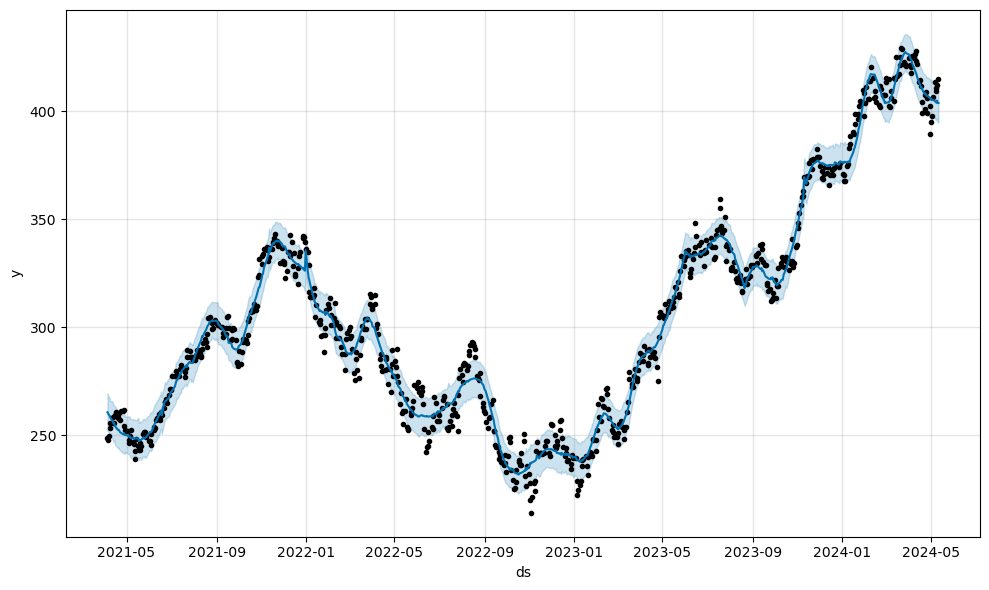

In [187]:
# 저장된 모델 파라미터를 파일로 저장


# 저장된 모델 파라미터를 불러오는 함수
def load_prophet_model_parameters(file_path):
    with open(file_path, 'rb') as f:
        model_params = pickle.load(f)
    return model_params
    
loaded_model_parameters = load_prophet_model_parameters('prophet_model_parameters_MSFT.pkl')

# Prophet 모델 생성 및 파라미터 설정
loaded_model = Prophet(
    changepoint_prior_scale=loaded_model_parameters['changepoint_prior_scale'],
    seasonality_prior_scale=loaded_model_parameters['seasonality_prior_scale'],
    holidays_prior_scale=loaded_model_parameters['holidays_prior_scale'],
    seasonality_mode=loaded_model_parameters['seasonality_mode'],
    changepoint_range=loaded_model_parameters['changepoint_range'],
    yearly_seasonality=loaded_model_parameters['yearly_seasonality'],
    weekly_seasonality=loaded_model_parameters['weekly_seasonality'],
    daily_seasonality=loaded_model_parameters['daily_seasonality'],
    growth=loaded_model_parameters['growth'],
    n_changepoints=loaded_model_parameters['n_changepoints']
)
loaded_model.add_country_holidays(country_name='US')

loaded_model.add_regressor('predict')

# 데이터 학습
loaded_model.fit(finance_df)
future = loaded_model.make_future_dataframe( periods = 1)
future['predict'] = result_filtered_future['predict'].values
# 주가 예측
forecast = loaded_model.predict(future)

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
''' 

# 모델 예측 결과 출력
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# 모델 예측 그래프 출력
fig = loaded_model.plot(forecast)

plt.show(fig)


In [104]:
finance_df

,ds,y,predict
0,2021-04-05,360.820007,1.100
1,2021-04-06,360.119995,0.591
2,2021-04-07,358.809998,0.972
3,2021-04-08,361.220001,1.000
4,2021-04-09,363.209991,1.000
...,...,...,...
777,2024-05-06,756.450012,1.125
778,2024-05-07,771.309998,1.102
779,2024-05-08,763.409973,1.071
780,2024-05-09,779.039978,1.083


In [68]:
# import pickle

# # 모델 객체를 파일로 저장
# with open("prophet_model_AVGO.pkl", "wb") as f:
#     pickle.dump(model, f)


In [98]:

# with open("prophet_model_AVGO.pkl", "rb") as f:
#     model = pickle.load(f)

# # 크로스 밸리데이션 설정
# df_cv = cross_validation(model, initial='250 days', period='20 days', horizon='1 days')

# # 크로스 밸리데이션 결과의 성능 지표 계산
# df_p = performance_metrics(df_cv)
# print(df_p[['rmse', 'mae','mape']])


In [99]:
# import pickle
# import logging
# import matplotlib.pyplot as plt
# from prophet import Prophet

# # cmdstanpy 로그 수준 설정
# logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# # 저장된 모델 파일을 로드
# with open("prophet_model_AVGO.pkl", "rb") as f:
#     model = pickle.load(f)

# # 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값
# future = model.make_future_dataframe(periods=1)
# future['predict'] = result_filtered_future['predict'].values[len(result_filtered_future['predict'].values)-756:]

# # 주가 예측
# forecast = model.predict(future)

# # 모델 예측 결과 출력
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# # 모델 예측 그래프 출력
# fig = model.plot(forecast)
# plt.show(fig)

# print(finance_df.tail(11))
# print(future['predict'].tail(11))


In [ ]:
# from prophet.diagnostics import cross_validation, performance_metrics
# import matplotlib.pyplot as plt
# model = Prophet( changepoint_prior_scale= 0.4469497270584068, 
# changepoint_range= 0.8117567477475541, 
# daily_seasonality= True,
# seasonality_mode='multiplicative',
# growth= 'linear', 
# holidays_prior_scale= 0.05160382047585584, 
# n_changepoints= 22, 
# seasonality_prior_scale= 0.3523031728392127, 
# weekly_seasonality= False, 
# yearly_seasonality= True
#                ) 

# model.add_country_holidays(country_name='US')
# model.add_regressor('predict')
# # 데이터와 Prophet 모델 설정 부분은 생략하고, 모델 학습 부분부터 시작
# model.fit(finance_df)

# # 크로스 밸리데이션 설정
# df_cv = cross_validation(model, initial='20 days', period='2 days', horizon='1 days')

# # 크로스 밸리데이션 결과의 성능 지표 계산
# df_p = performance_metrics(df_cv)
# print(df_p[['rmse', 'mae','mape']])


In [162]:
import pandas as pd

# 초기 자본 설정
initial_capital = 100000000.0


# def trading():
# 사용자로부터 시작일과 종료일 입력 받기
start_date = '2024-04-05'
end_date_1 = '2024-05-10'
end_date_2 = '2024-05-11'

# 입력된 날짜 범위로 데이터 필터링
filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
filtered_df_forcast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]
# 현재 자본 및 보유 주식 수 초기화
current_capital = initial_capital
shares_owned = 0

# 현재 포지션 초기화
position = 'None'

# 실제 및 예측 주식 가격 설정
actual_prices = filtered_df.set_index('ds')['y']
predicted_prices = filtered_df_forcast.set_index('ds')['yhat']

# 시뮬레이션 시작
for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
    predicted_change = predicted_next_day_price - today_price

    # 매수 조건
    if predicted_change > 0 and position != 'Hold':
        shares_to_buy = current_capital / today_price
        shares_owned += shares_to_buy
        current_capital -= shares_to_buy * today_price
        position = 'Hold'
        print(f"{date} - 매수: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

    # 매도 조건
    elif predicted_change < 0 and position == 'Hold':
        current_capital += shares_owned * today_price
        shares_owned = 0
        position = 'None'
        print(f"{date} - 매도: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

    # 보유 조건
    elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
        print(f"{date} - 보유: ${today_price:.3f}")
    else:
        # 조치 없음 또는 보유
        if position == 'Hold':
            print(f"{date} - 보유: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")
        else:
            print(f"{date} - 조치 없음: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")

# 최종 자본 및 수익률 계산
final_capital = current_capital + (shares_owned * actual_prices.iloc[-1])
profit = final_capital - initial_capital
return_rate = (profit / initial_capital) * 100

# 결과 출력
print(f"초기 자본: ${initial_capital:.3f}")
print(f"최종 자본: ${final_capital:.3f}")
print(f"수익: ${profit:.3f}")
print(f"수익률: {return_rate:.3f}%")


2024-04-05 00:00:00 - 매수: $153.940 (예측 다음날 가격: $156.207)
2024-04-08 00:00:00 - 보유: $156.140
2024-04-09 00:00:00 - 매도: $158.140 (예측 다음날 가격: $156.772)
2024-04-10 00:00:00 - 조치 없음: 현재 가격 $157.660, 예측 다음날 가격 $157.175
2024-04-11 00:00:00 - 조치 없음: 현재 가격 $160.790, 예측 다음날 가격 $157.442
2024-04-12 00:00:00 - 조치 없음: 현재 가격 $159.190, 예측 다음날 가격 $158.362
2024-04-15 00:00:00 - 매수: $156.330 (예측 다음날 가격: $158.548)
2024-04-16 00:00:00 - 보유: 현재 가격 $156.000, 예측 다음날 가격 $158.779
2024-04-17 00:00:00 - 보유: 현재 가격 $156.880, 예측 다음날 가격 $159.415
2024-04-18 00:00:00 - 보유: 현재 가격 $157.460, 예측 다음날 가격 $159.846
2024-04-19 00:00:00 - 보유: 현재 가격 $155.720, 예측 다음날 가격 $160.814
2024-04-22 00:00:00 - 보유: 현재 가격 $157.950, 예측 다음날 가격 $161.319
2024-04-23 00:00:00 - 보유: 현재 가격 $159.920, 예측 다음날 가격 $161.656
2024-04-24 00:00:00 - 보유: $161.100
2024-04-25 00:00:00 - 보유: 현재 가격 $157.950, 예측 다음날 가격 $162.909
2024-04-26 00:00:00 - 매도: $173.690 (예측 다음날 가격: $164.390)
2024-04-29 00:00:00 - 조치 없음: 현재 가격 $167.900, 예측 다음날 가격 $164.894
2024-04-30 00:00:00

In [73]:
def simulate_trading(start_date, end_date_1,end_date_2):
    # 입력된 날짜 범위로 데이터 필터링
    filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
    filtered_df_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]

    # 현재 자본 및 보유 주식 수 초기화
    current_capital = initial_capital
    shares_owned = 0

    # 현재 포지션 초기화
    position = 'None'

    # 실제 및 예측 주식 가격 설정
    actual_prices = filtered_df.set_index('ds')['y']
    predicted_prices = filtered_df_forecast.set_index('ds')['yhat']

    # 거래 기록 초기화
    trading_history = []

    # 시뮬레이션 시작
    for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
        predicted_change = predicted_next_day_price - today_price

        # 매수 조건
        if predicted_change > 0 and position != 'Hold':
            shares_to_buy = current_capital / today_price
            shares_owned += shares_to_buy
            current_capital -= shares_to_buy * today_price
            position = 'Hold'
            trading_history.append((date, '매수', today_price, predicted_next_day_price))

        # 매도 조건
        elif predicted_change < 0 and position == 'Hold':
            current_capital += shares_owned * today_price
            shares_owned = 0
            position = 'None'
            trading_history.append((date, '매도', today_price, predicted_next_day_price))

        # 보유 조건
        elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
            trading_history.append((date, '보유', today_price, predicted_next_day_price))

        # 조치 없음 또는 보유
        else:
            if position == 'Hold':
                trading_history.append((date, '보유', today_price, predicted_next_day_price))
            else:
                trading_history.append((date, '조치 없음', today_price, predicted_next_day_price))

    # 최종 자본 및 수익률 계산
    final_capital = current_capital + (shares_owned * actual_prices.iloc[-1])
    profit = final_capital - initial_capital
    return_rate = (profit / initial_capital) * 100

    return trading_history, final_capital, return_rate

# 주어진 날짜 범위로 거래 시뮬레이션 실행
start_date = '2024-04-05'
end_date_1 = '2024-05-09'
end_date_2 = '2024-05-10'
trading_history, final_capital, return_rate = simulate_trading(start_date, end_date_1,end_date_2)

# 거래 기록 출력
# for record in trading_history:
#     print(f"{record[0]} - {record[1]}: 현재 가격 ${record[2]:.3f}, 예측 다음날 가격 ${record[3]:.3f}")

# 최종 자본 및 수익률 출력
print(f"최종 자본: ${final_capital:.2f}")
print(f"수익률: {return_rate:.2f}%")



최종 자본: $101897618.31
수익률: 1.90%


In [161]:
def simulate_trading(start_date, end_date_1, end_date_2):
    # 입력된 날짜 범위로 데이터 필터링
    filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
    filtered_df_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]

    # 현재 자본 및 보유 주식 수 초기화
    current_capital = initial_capital
    shares_owned = 0

    # 현재 포지션 초기화
    position = 'None'

    # 실제 및 예측 주식 가격 설정
    actual_prices = filtered_df.set_index('ds')['y']
    predicted_prices = filtered_df_forecast.set_index('ds')['yhat']

    # 거래 기록 초기화
    trading_history = []

    # 시뮬레이션 시작
    for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
        predicted_change = predicted_next_day_price - today_price

        # 매수 조건
        if predicted_change > 0 and position != 'Hold':
            shares_to_buy = current_capital / today_price
            shares_owned += shares_to_buy
            current_capital -= shares_to_buy * today_price
            position = 'Hold'
            trading_history.append('Buy')

        # 매도 조건
        elif predicted_change < 0 and position == 'Hold':
            current_capital += shares_owned * today_price
            shares_owned = 0
            position = 'None'
            trading_history.append('Cell')

        # 보유 조건
        elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
            trading_history.append('Hold')

        # 조치 없음 또는 보유
        else:
            if position == 'Hold':
                trading_history.append('Hold')
            else:
                trading_history.append('Stay')#조치없음

    # 최종 자본 및 수익률 계산

    # trading_history의 마지막 인덱스 반환
    last_record = trading_history[-1]
    return last_record

# 함수 호출하여 마지막 인덱스 값만 출력
start_date = '2024-04-05'
end_date_1 = '2024-05-10'
end_date_2 = '2024-05-11'
last_trading_record = simulate_trading(start_date, end_date_1, end_date_2)
print(last_trading_record)




Hold


In [ ]:
# end_date_basic = input('날짜를 입력하게요 ex)2024-05-07')
# end_date_future = input('날짜를 입력하게요 ex)2024-05-07')
# trainding(end_date_basic,end_date_future)